In [29]:
from pyspark.sql import SparkSession

# spark = SparkSession.builder \
#     .config("spark.driver.memory", "1g") \
#     .config("spark.executor.memory", "9g") \
#     .config("spark.executor.instances", 7) \
#     .getOrCreate()

spark = SparkSession.builder \
    .master("spark://exp-1-04.expanse.sdsc.edu:7077") \
    .config("spark.executor.instances", 7) \
    .config("spark.executor.cores", 1) \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

Justification for the config:
- Driver memory = 1 GB (fixed, small)
- Executor instances = Total Cores - 1  (reserve 1 for driver) = 7 
- Executor memory = (Total Memory - Driver Memory) / Executor Instances = (64 - 1) / 7 = 9
- Total: 8 cores | 64 GB

In [30]:
print(spark.sparkContext.uiWebUrl)

http://exp-1-04.expanse.sdsc.edu:4040


In [31]:
data_path = "/expanse/lustre/projects/uci157/awatson4/datasets/taxi"

df = spark.read.parquet(data_path)

### SparkUI show multiple executors active during data loading

![SparkUI](data_loading.png)

In [4]:
df.printSchema()
df.show(5)

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: integer (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+---

### Data Exploration
*How many observations does your dataset have?*

In [5]:
df.count()

140151844

In [6]:
df.groupBy("passenger_count").count().show()

+---------------+--------+
|passenger_count|   count|
+---------------+--------+
|            8.0|     384|
|            0.0| 2719138|
|            7.0|     585|
|           NULL| 2733045|
|            1.0|98122695|
|            4.0| 2566033|
|            3.0| 5620491|
|            2.0|20555368|
|            6.0| 2966021|
|            5.0| 4867771|
|            9.0|     311|
|          112.0|       1|
|           96.0|       1|
+---------------+--------+



In [7]:
df.groupBy("VendorID", "PULocationID").count().show()

+--------+------------+-------+
|VendorID|PULocationID|  count|
+--------+------------+-------+
|       1|         185|   1691|
|       1|          94|   1041|
|       1|          51|   2477|
|       2|         179|  43171|
|       2|          52|  43261|
|       4|          61|     15|
|       1|          96|    432|
|       4|         238|   4368|
|       2|         227|   5674|
|       2|          76|  39356|
|       1|         176|     20|
|       5|          41|      5|
|       2|         230|2844901|
|       4|         261|   1562|
|       2|         157|   9917|
|       5|         161|     14|
|       1|         138|1075811|
|       2|          41| 426463|
|       1|         158| 457328|
|       2|         133|   7995|
+--------+------------+-------+
only showing top 20 rows



df.select("airport_fee").distinct().show()

Categorical Variables (Nominal Scale)
* VendorID (long): nominal, taxi provider ID, small number of discrete values
* RatecodeID (double): nominal, fare rate category, values represent pricing rules
* store_and_fwd_flag (string): binary categorical, Values: Y / N, whether trip data was stored before transmission
* PULocationID / DOLocationID (long): nominal, pickup and dropoff zones, high-cardinality categorical variables
* payment_type (long): payment method with multiple discrete classes
* airport_fee (integer): categorical / binary-like, airport surcharge presence

Interval Scale Variables
* tpep_pickup_datetime / tpep_dropoff_datetime: timestamp (interval), used to compute trip duration, distribution reflects human activity patterns

In [11]:
from pyspark.sql.functions import expr

df = df.withColumn(
    "trip_duration_minutes",
    expr("timestampdiff(MINUTE, tpep_pickup_datetime, tpep_dropoff_datetime)")
)
df.show(10)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|trip_duration_minutes|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------------------+
|       1| 2019-03-01 00:24:41|  2019-03-01 00:25:31|            1.0|          0.0|       1.0|                 N|        

Continuous Variables (Ratio Scale)

* trip_distance (double):    Continuous positive variable. Right-skewed distribution (many short trips).
* fare_amount (double):    Continuous monetary value. Positively skewed.
* extra, mta_tax, improvement_surcharge, congestion_surcharge (double)
    Continuous but low-variance monetary adjustments.
* tip_amount (double):    Continuous non-negative variable. Highly right-skewed with many zeros.
* tolls_amount (double):    Continuous zero-inflated variable.
* total_amount (double):    Continuous monetary variable representing total trip cost. Strongly right-skewed.
* passenger_count (double):    Discrete count variable with small integer range.

In [9]:
from pyspark.sql.functions import min, max

df.select(min("trip_distance"), max("trip_distance")).show()
df.select(min("fare_amount"), max("fare_amount")).show()
df.select(min("total_amount"), max("total_amount")).show()
df.select(min("trip_duration_minutes"), max("trip_duration_minutes")).show()

+------------------+------------------+
|min(trip_distance)|max(trip_distance)|
+------------------+------------------+
|         -37264.53|         351613.36|
+------------------+------------------+

+----------------+----------------+
|min(fare_amount)|max(fare_amount)|
+----------------+----------------+
|         -1856.0|       998310.03|
+----------------+----------------+

+-----------------+-----------------+
|min(total_amount)|max(total_amount)|
+-----------------+-----------------+
|          -1871.8|       1084772.17|
+-----------------+-----------------+

+--------------------------+--------------------------+
|min(trip_duration_minutes)|max(trip_duration_minutes)|
+--------------------------+--------------------------+
|                   -531231|                     43648|
+--------------------------+--------------------------+



In [10]:
from pyspark.sql.functions import col

print(df.filter(col("trip_distance") < 0).count())
print(df.filter(col("fare_amount") < 0).count())
print(df.filter(col("total_amount") < 0).count())
print(df.filter(col("trip_duration_minutes") < 0).count())

11440
402214
402388
1799


In [10]:
from pyspark.sql.functions import col

df_clean = df.filter(
    (col("trip_distance") >= 0) &
    (col("fare_amount") >= 0) &
    (col("total_amount") >= 0) &
    (col("trip_duration_minutes") >= 0)
)

In [12]:
from pyspark.sql.functions import min, max

df_clean.select(min("trip_distance"), max("trip_distance")).show()
df_clean.select(min("fare_amount"), max("fare_amount")).show()
df_clean.select(min("total_amount"), max("total_amount")).show()
df_clean.select(min("trip_duration_minutes"), max("trip_duration_minutes")).show()

+------------------+------------------+
|min(trip_distance)|max(trip_distance)|
+------------------+------------------+
|               0.0|         351613.36|
+------------------+------------------+

+----------------+----------------+
|min(fare_amount)|max(fare_amount)|
+----------------+----------------+
|             0.0|       998310.03|
+----------------+----------------+

+-----------------+-----------------+
|min(total_amount)|max(total_amount)|
+-----------------+-----------------+
|              0.0|       1084772.17|
+-----------------+-----------------+

+--------------------------+--------------------------+
|min(trip_duration_minutes)|max(trip_duration_minutes)|
+--------------------------+--------------------------+
|                         0|                     43648|
+--------------------------+--------------------------+



Target column: **total_amount**
- expecting right-skewed data, guessing most taxi rides are short with outliers of long trips

In [13]:
from pyspark.sql.functions import min, max, mean

df_clean.select(
    min("total_amount").alias("min_total"),
    max("total_amount").alias("max_total"),
    mean("total_amount").alias("mean_total")
).show()

+---------+----------+------------------+
|min_total| max_total|        mean_total|
+---------+----------+------------------+
|      0.0|1084772.17|19.264895246816028|
+---------+----------+------------------+



*Do you have missing and duplicate values in your dataset?*

In [27]:
from pyspark.sql.functions import col, sum, when
from pyspark.sql import functions as F

has_missing = df.where(F.col("passenger_count").isNull()).limit(1).count() > 0
print("Has missing values?", has_missing)

Has missing values? True


In [28]:
key_cols = [
    "VendorID", "tpep_pickup_datetime", "tpep_dropoff_datetime",
    "PULocationID", "DOLocationID", "trip_distance", "fare_amount", "total_amount"
]

has_dups = (df.groupBy(*key_cols)
              .count()
              .where(F.col("count") > 1)
              .limit(1)
              .count() > 0)

print("Has duplicate trips by key?", has_dups)

Has duplicate trips by key? True


# Data Plots

In [13]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

Matplotlib created a temporary cache directory at /tmp/matplotlib-bvej7vsx because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


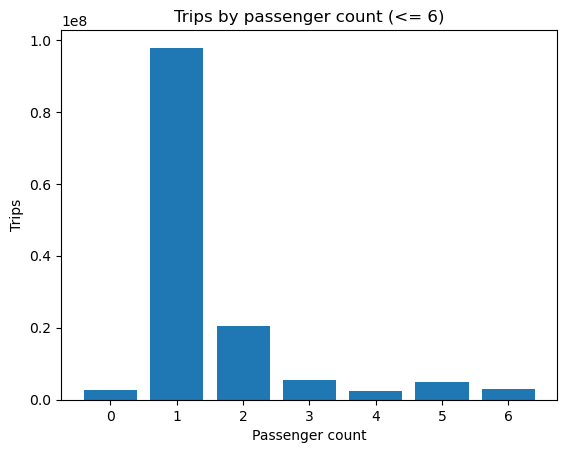

In [32]:
# trips by passenger_count
#
# Number of trips for each passenger count from 0 to 6.
#
# - The distribution is extremely skewed toward 1 passenger, with 2 passengers being the next most common group.
# - Passenger counts 3–6 are much less frequent.
# - Most taxi rides are solo trips, consistent with typical urban taxi usage.
# - The presence of 0 passengers indicates data-entry issues, canceled trips, or system artifacts and should be treated as a data-quality edge case.

pc_rows = (df_clean
    .groupBy("passenger_count")
    .count()
    .where(F.col("passenger_count").isNotNull())
    .where(F.col("passenger_count") <= 6)
    .orderBy("passenger_count")
    .collect()
)

x = [int(r["passenger_count"]) for r in pc_rows]
y = [int(r["count"]) for r in pc_rows]

plt.figure()
plt.bar(x, y)
plt.xlabel("Passenger count")
plt.ylabel("Trips")
plt.title("Trips by passenger count (<= 6)")
plt.show()

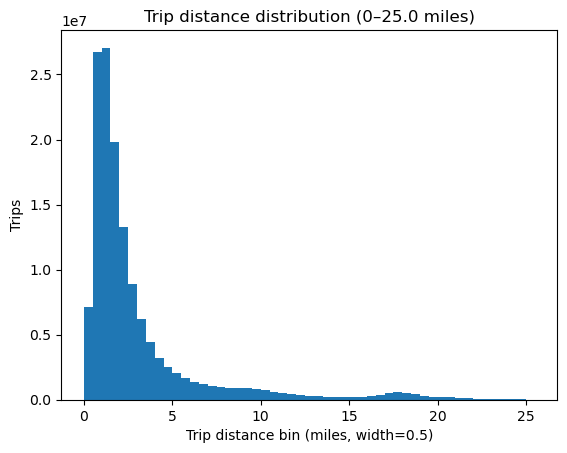

In [16]:
# trip_distance distribution
# Count of trips within distance bins (width = 0.5 miles), restricted to 0–25 miles.
#
# **Observation:**
# - A very strong concentration of trips at short distances (roughly under 3–5 miles).
# - A long right tail: fewer trips extend to 10–25 miles.
# - A small bump at higher distances can appear due to consistent long routes (for example, airport-area patterns).

# **Insights:**
# - Trip distances are heavily right-skewed, so averages can be influenced by outliers.
# - Medians and percentiles are often more informative than the mean.

                                                                             
bin_width = 0.5  # miles
max_dist = 25.0

dist_bins = (df_clean
    .where(F.col("trip_distance").isNotNull())
    .where((F.col("trip_distance") >= 0) & (F.col("trip_distance") <= max_dist))
    .withColumn("bin", (F.floor(F.col("trip_distance") / F.lit(bin_width)) * F.lit(bin_width)).cast("double"))
    .groupBy("bin")
    .count()
    .orderBy("bin")
    .collect()
)

bins = [float(r["bin"]) for r in dist_bins]
counts = [int(r["count"]) for r in dist_bins]

plt.figure()
plt.bar(bins, counts, width=bin_width, align="edge")
plt.xlabel(f"Trip distance bin (miles, width={bin_width})")
plt.ylabel("Trips")
plt.title(f"Trip distance distribution (0–{max_dist} miles)")
plt.show()

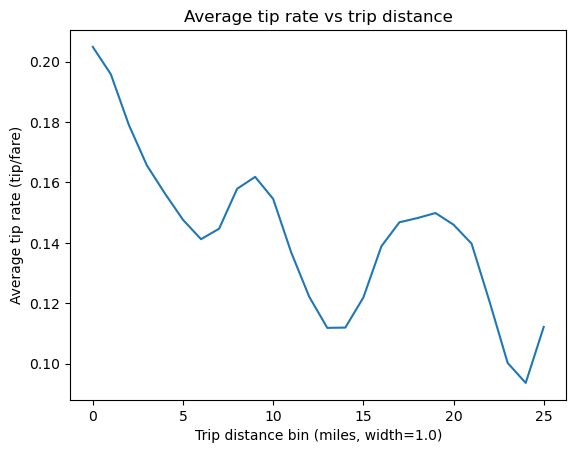

In [17]:
# average tip rate by trip distance
# Average tip rate (`tip_amount / fare_amount`) aggregated by 1-mile distance bins.
# - Tip rate is not constant across distances.
# - Tip rate starts relatively higher for very short trips, then generally decreases and fluctuates across longer distances.

# **Insights:**
# - Tipping behavior depends on trip characteristics and is not purely proportional to distance.
# - Short rides can show higher average tip rate because tips often follow discrete habits (e.g., rounding or fixed-dollar tips), which are larger relative to a small fare.
# - Fluctuations at longer distances can reflect changing rider mix, route types (e.g., airport vs non-airport), and bins with fewer trips can be noisier.

bin_width = 1.0
max_dist = 25.0

tip_by_dist = (df_clean
    .where((F.col("trip_distance").isNotNull()) & (F.col("fare_amount") > 0))
    .where((F.col("trip_distance") >= 0) & (F.col("trip_distance") <= max_dist))
    .withColumn("dist_bin", (F.floor(F.col("trip_distance") / F.lit(bin_width)) * F.lit(bin_width)).cast("double"))
    .withColumn("tip_rate", (F.col("tip_amount") / F.col("fare_amount")))
    .where((F.col("tip_rate") >= 0) & (F.col("tip_rate") <= 1.0))  # trim extreme anomalies
    .groupBy("dist_bin")
    .agg(
        F.avg("tip_rate").alias("avg_tip_rate"),
        F.count("*").alias("n")
    )
    .where(F.col("n") >= 1000)   # reduce noise; adjust if needed
    .orderBy("dist_bin")
    .collect()
)

x = [float(r["dist_bin"]) for r in tip_by_dist]
y = [float(r["avg_tip_rate"]) for r in tip_by_dist]

plt.figure()
plt.plot(x, y)
plt.xlabel(f"Trip distance bin (miles, width={bin_width})")
plt.ylabel("Average tip rate (tip/fare)")
plt.title("Average tip rate vs trip distance")
plt.show()

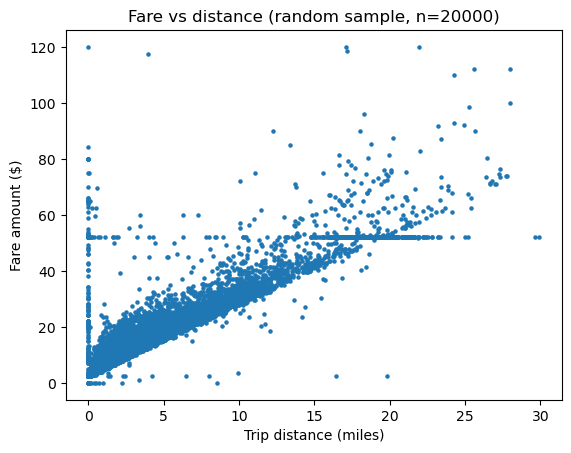

In [19]:
# fare vs distance
# fare_amount` versus `trip_distance` for a random sample of trips
# **Observation:**
# - A clear positive relationship: fares generally increase with distance.
# - A dense diagonal “fan” pattern indicates typical per-mile pricing plus variability.
# - A visible vertical cluster near 0 miles with non-zero fares.
# - A noticeable horizontal band where many fares are similar across a range of distances.

# **Insights:**
# - Distance is a strong driver of fare, but fare is not determined by distance alone.
# - Near-0 distance trips with non-zero fare suggest artifacts, minimum fares, or special cases that may need filtering.
# - The horizontal band suggests a flat-fare or special-rate regime (often tied to rate codes or common routes).
# - Outliers indicate unusual pricing cases, reporting errors, or special trip conditions.


sample_n = 20000

sample_rows = (df_clean
    .select("trip_distance", "fare_amount", "trip_duration_minutes")
    .where(
        (F.col("trip_distance").isNotNull()) &
        (F.col("fare_amount").isNotNull()) &
        (F.col("trip_distance") >= 0) & (F.col("trip_distance") <= 30) &
        (F.col("fare_amount") >= 0) & (F.col("fare_amount") <= 150)
    )
    .orderBy(F.rand())
    .limit(sample_n)
    .collect()
)

x = [float(r["trip_distance"]) for r in sample_rows]
y = [float(r["fare_amount"]) for r in sample_rows]

plt.figure()
plt.scatter(x, y, s=5)
plt.xlabel("Trip distance (miles)")
plt.ylabel("Fare amount ($)")
plt.title(f"Fare vs distance (random sample, n={sample_n})")
plt.show()

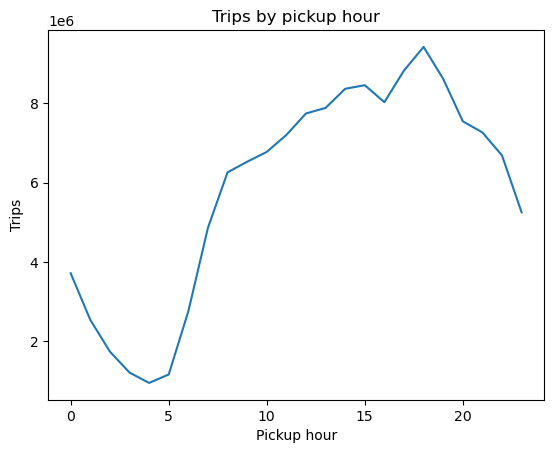

In [20]:
# time-of-day
# Total number of trips aggregated by pickup hour (0–23).
# **Observation:**
# - Very low trip volume in early morning hours
# - A sharp rise starting in the morning, staying high through the day.
# - Peak activity in late afternoon/early evening, followed by a decline at night.

# **Insights:**
# - Pickup hour is an important derived feature correlated with rider behavior, congestion, and potentially fare/tip patterns.
# - This supports feature engineering such as `pickup_hour`, `day_of_week`, and “rush-hour” indicators.

    
by_hour = (df_clean
    .withColumn("pickup_hour", F.hour("tpep_pickup_datetime"))
    .groupBy("pickup_hour")
    .count()
    .orderBy("pickup_hour")
    .collect()
)

x = [int(r["pickup_hour"]) for r in by_hour]
y = [int(r["count"]) for r in by_hour]

plt.figure()
plt.plot(x, y)
plt.xlabel("Pickup hour")
plt.ylabel("Trips")
plt.title("Trips by pickup hour")
plt.show()